# Individual Assignment 2

### (Due on Sep 15 11:59PM on LumiNUS)
- Student Name: Tommy Kangdra
- Student ID: A0218866N

## Problem 1 (GrabWheels)
Towards the smart nation initiative, the Government of Singapore has encouraged sustainable and smart mobility solutions such as recent scooter vehicle sharing (e.g., GrabWheels).
Launched in the late 2018, GrabWheels rolled out around 30 parking locations in NUS Kent Ridge campus. For more details, please see http://news.nus.edu.sg/press-releases/new-e-scooter-sharing-service and https://www.grab.com/sg/wheels/.
A group of DBA5106 students is working on a project in the design and operations of GrabWheels at NUS campus, e.g., where to set up the parking locations and how many scooters to place at each location. Please answer the following questions.

#### a) Suppose GrabWheels wants to improve its service quality by optimizing parking locations and calculating the optimal number of scooters at each location. Please suggest what information would help and what data GrabWheels needs to be collected. [2 pts]


#### Answer:
**With assumption that GrabWheels already rolled out the parking locations, and the scooter, the information to be collectted will be:**
1. The coordinates of each station with the id
2. The usage of the scooter
- The timestamp of the start and end of usage
- The bike ID
- The starting and ending location

#### b) By Sep 2019, GrabWheels has collected 2-month data (you specified in part a) from its operating 30 locations. To forecast the demand for new locations, e.g., COM2, briefly discuss which data mining task should be performed and what additional data sets should be collected, if any. [2 pts]

#### Answer:
**Data mining task to be performed:**
1. Descriptive Analysis to understand the demographics of the users around the COM2
2. Descriptive Analysis to see the trips to and fro at the nearest bus stop around COM2
2. Predictive Analysis to predict the demand at COM2 and the numbers of bike needed: Regression 
3. Time Series Analysis will also help to see any seasonality that may happen (e.g. academic year)

**Additional Data that may be needed to be collected:**
1. the Academic Years from NUS: to understand the seasonality

#### c) Following part (b), briefly discuss how GrabWheels can forecast the demand scooter sharing at new locations, using your proposed approach. Please identify which steps are the process of data mining (DM), or the use of the results of data mining (Use). [2 pts]

1. to understand the data with Descriptive Analysis, on the capacity utilization :
- **[DM]** The current capacity of each station able to hold the scooter (e.g. during start, peak hours and end of the days, how many bikes are in the stations)
- **[DM]** The usage of the bikes by counting the number of trips for different start and end stations that is nearby the new locations
- **[DM]** The demographics of the subscriber in NUS (e.g. which location do subscribers spend most of their time in Kent Ridge Campus)

2. to build model to do predictive Predicitive Analysis
- **[USE]** Linear regression to predict the capacity utilization and the numbers of bikes
- **[USE]** Time Series Analysis to predict the number of bikes and capacity utilization during different seasonality (e.g. during term breaks)

#### d) Discuss what challenges GrabWheels may face and how data analytics can help improve its operations. [2 pts]

1. The abundance amount of collected data
2. The qualities of the collected data 
3. Intrepreting the data 
4. Making Business Decision from the Data

Data Analytics helps in:
- Data Cleansing (e.g. with missing values and inaccurate informations, outliers) 
- Feature Engineering: to get the best and useful informations out of the data
- Descriptive Analysis: to understand the data especially tvisually, seeing patterns, trends
- Predictive Analysis: to build model that accurately predict the number of bikes, the location of new stations to achieve the business purpose (e.g. customer satisfcation, or increase number of subscriber)

#### e) If you are evaluating the market expansion plan of GrabWheels, e.g., whether it should cover certain regions, describe what data you would like to collect and how you would like to collect and analyze them for such an evaluation? [2 pts]

**Data to be collected:**
1. Demographics of the population (e.g. number of peoples, age distribution)
2. List of public facilities with (coordinates that are majorly used by people) e.g. Library, Printing service, Mini Market, Canteen, Main Lecture Theatre
3. The likelihood of people (from different department) to utilize the GrabWheels that can be gathered through Survey
4. Historical data of Grab Wheels in other areas, the utilization rate of the scooter vs the population/crowd in the area (that can be used to predict)
5. The GPS position of people (who consent to provide information, with incentives) for a period of time, to see the footfall


## Problem 2 (Blue Bikes)
A renowned consulting firm MSBA & Company is currently analyzing the trip data of Blue Bikes (originally Hubway) in Boston. Blue Bikes (https://www.bluebikes.com/) is a public bike share system that operates in the Greater Boston area.

We are interested in exploring the bike share operations from the data available on https://www.bluebikes.com/system-data. We will utilize the “Bluebikes trip history data” as well as “the list of GPS coordinates and number of docks for each station” available on the website.

Please download and analyze the data to answer the following questions.
[Note: (1) the unzipped “201906-bluebikes-tripdata.zip” has a wrong file name (with correct data
  inside);
(2) you can add extension “.csv” to the unzipped “201907-bluebikes-tripdata” file]

#### 1. Provide the line chart of monthly trips from 2015-06 to 2020-05. [2 pts]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing 

#Initialize the Variable with starting values 
data_list = (glob.glob("C:/Users/tommy/OneDrive/(PYTHON)/5106/Assignment 2/*.csv"))
df_all = pd.DataFrame()
trips = []
dates = []

#Appending all other datas with additional values
for n in range(60):
    df = pd.read_csv(data_list[n], usecols = ['tripduration', 'starttime'])
    trips.append(len(df))
    dates.append(pd.to_datetime(df['starttime'][0]))
    df_all = pd.concat([df_all,df], axis=0, ignore_index = True)
del df_all

ser = pd.Series(dates, name= 'Date').dt.date

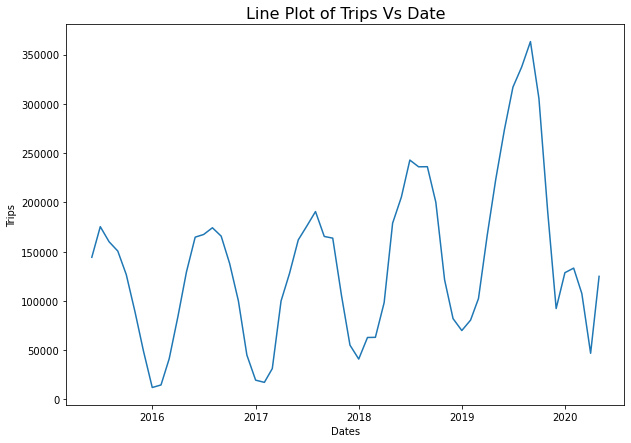

In [2]:
plt.figure(figsize = (10,7))
plt.plot(ser, trips)
plt.title('Line Plot of Trips Vs Date', fontsize = 16)
plt.xlabel('Dates')
plt.ylabel('Trips')

bikes_df = pd.DataFrame({'Date': ser, 'Trip': trips})
init=bikes_df

#### 2. Discuss any observed patterns, e.g., trend, seasonality, and shocks. Support your argument with necessary data, if possible. [2 pts]

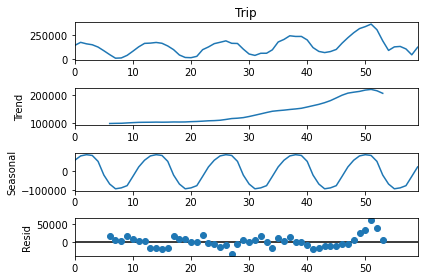

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(bikes_df['Trip'], model='additive', period = 12)
result.plot()
pyplot.show()

#### Observation:
- Observed an upward from the year 2016 - 2020
- Annual Seasonality, on October - January there is a tremendous drop in the total trips, perhaps as it is winter season, that it's too cold to use the bike
- In 2019 October there is a shock, sudden surge of use of bikes
- In 2020 March there is sudden drop, perhaps due to covid-19

#### 3. Implement the following forecasting methods to forecast the monthly trips from 2019-06 to 2020-05. (Note that, when forecasting for month t+1, the history from 2015-06 up to month t are available.)
#### a. Provide your forecasts using a 3-month moving average. [1 pts]

In [4]:
n_moving_average = 3

fitted_values= list(bikes_df['Trip'].rolling(n_moving_average).mean())
fitted_values.pop(len(fitted_values)-1)

bikes_df= pd.concat([bikes_df, 
                     pd.DataFrame(fitted_values[47:], index= bikes_df.index[48:], columns=['MA_forecast'])]
                    ,axis=1)
del fitted_values
bikes_df['MA_forecast'] = bikes_df['MA_forecast'].round(0)
bikes_df.tail(12)

,Date,Trip,MA_forecast
48,2019-06-01,274022,164049.0
49,2019-07-01,316931,221267.0
50,2019-08-01,337443,271346.0
51,2019-09-01,363185,309465.0
52,2019-10-01,305504,339186.0
53,2019-11-01,190759,335377.0
54,2019-12-01,92208,286483.0
55,2020-01-01,128598,196157.0
56,2020-02-01,133235,137188.0
57,2020-03-01,107350,118014.0


#### Observation 3a:
We observe that the Moving Average prediction is not very good in predicting the trips, as the data is observed with seasonality and trend, the prediction become lagging as it took the average of the previous 3 months.

#### b. Provide your forecasts using exponential smoothing with a smoothing constant α=0.5. [1 pts]

Using Simple Exponential Smoothing to the actual data trips

In [5]:
bikes_df_test = bikes_df.iloc[-12:,:2]
SES_forecast = []
SES_index=[]

for i in range(12):
    bikes_df_train = bikes_df.iloc[:-12+i,:2]
    SES_model = SimpleExpSmoothing(bikes_df_train['Trip'].astype('float')).fit(smoothing_level = 0.5)
    SES_forecast.append(round(SES_model.forecast().values[0]))
    SES_index.append(SES_model.forecast().index)

bikes_df['SES_forecast'] = pd.DataFrame(SES_forecast, index = bikes_df.index[-12:])

bikes_df[['Date', 'Trip', 'SES_forecast']].tail(12)

C:\Users\tommy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,Date,Trip,SES_forecast
48,2019-06-01,274022,177127.0
49,2019-07-01,316931,225575.0
50,2019-08-01,337443,271253.0
51,2019-09-01,363185,304348.0
52,2019-10-01,305504,333766.0
53,2019-11-01,190759,319635.0
54,2019-12-01,92208,255197.0
55,2020-01-01,128598,173703.0
56,2020-02-01,133235,151150.0
57,2020-03-01,107350,142193.0


#### c. Provide your forecasts using Holt’s method with α=0.3 and β=0.1. [1 pts]

In [6]:
from statsmodels.tsa.api import Holt

Holts_forecast = []

for i in range(12):
    bikes_df_train = bikes_df['Trip'][:-12+i]
    Holter_model = Holt(bikes_df_train).fit(smoothing_level=0.3, smoothing_slope=0.1, optimized=False)
    Holts_forecast.append(round(Holter_model.forecast().values[0]))
    
bikes_df['Holts_forecast'] = pd.Series(Holts_forecast, index = bikes_df.index[-12:])
bikes_df[['Date', 'Trip', 'Holts_forecast']].tail(12)

,Date,Trip,Holts_forecast
48,2019-06-01,274022,155682.0
49,2019-07-01,316931,196216.0
50,2019-08-01,337443,241084.0
51,2019-09-01,363185,281536.0
52,2019-10-01,305504,320025.0
53,2019-11-01,190759,329227.0
54,2019-12-01,92208,297091.0
55,2020-01-01,128598,238884.0
56,2020-02-01,133235,205747.0
57,2020-03-01,107350,181767.0


#### d. Plot the forecasts from all three methods above in the line chart, together with the actual trips for the periods 2019-06 to 2020-05. [1 pts]

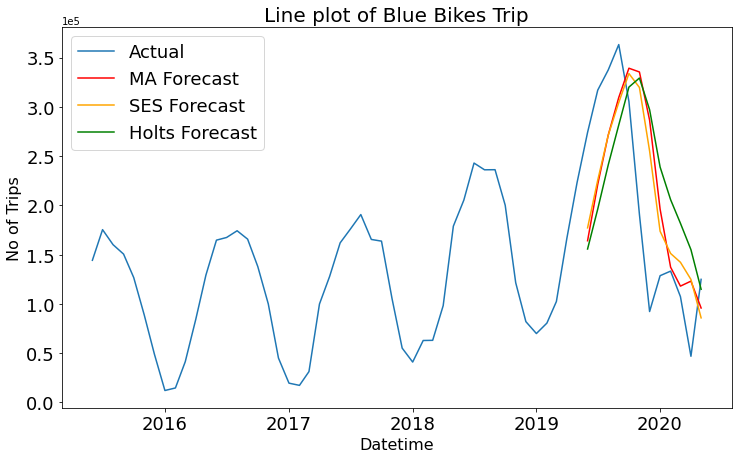

In [7]:
plt.figure(figsize = (12,7))
plt.plot(bikes_df['Date'], bikes_df['Trip'], label = 'Actual')
plt.plot(bikes_df['Date'], bikes_df['MA_forecast'], label = 'MA Forecast', color = 'red')
plt.plot(bikes_df['Date'], bikes_df['SES_forecast'], label = 'SES Forecast', color = 'orange')
plt.plot(bikes_df['Date'], bikes_df['Holts_forecast'], label = 'Holts Forecast', color = 'green')
plt.title('Line plot of Blue Bikes Trip', fontsize=20)
plt.ticklabel_format(axis = 'y', style= 'sci', scilimits =(0,3))
plt.xlabel('Datetime',fontsize=16)
plt.ylabel('No of Trips',fontsize=16)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.show()  

#### e. Evaluate the above forecasting methods using MAD (Mean Absolute Deviation) and MAPE, respectively. [1 pts]

In [8]:
bikes_df.tail(12)

,Date,Trip,MA_forecast,SES_forecast,Holts_forecast
48,2019-06-01,274022,164049.0,177127.0,155682.0
49,2019-07-01,316931,221267.0,225575.0,196216.0
50,2019-08-01,337443,271346.0,271253.0,241084.0
51,2019-09-01,363185,309465.0,304348.0,281536.0
52,2019-10-01,305504,339186.0,333766.0,320025.0
53,2019-11-01,190759,335377.0,319635.0,329227.0
54,2019-12-01,92208,286483.0,255197.0,297091.0
55,2020-01-01,128598,196157.0,173703.0,238884.0
56,2020-02-01,133235,137188.0,151150.0,205747.0
57,2020-03-01,107350,118014.0,142193.0,181767.0


In [9]:
from sklearn.metrics import mean_absolute_error

MA_forecast = np.array(bikes_df['MA_forecast'].iloc[-12:].values)
SES_forecast = np.array(bikes_df['SES_forecast'].iloc[-12:].values)
Holts_forecas = np.array(bikes_df['Holts_forecast'].iloc[-12:].values)
Actual = np.array(bikes_df['Trip'].iloc[-12:].values)

In [10]:
def Mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
MAPE_MA = Mape(Actual, MA_forecast)
MAPE_SES = Mape(Actual, SES_forecast)
MAPE_Holts = Mape(Actual, Holts_forecast)

print('MAD for MA forecast: {:.1f}'.format(mean_absolute_error(Actual,MA_forecast)))
print('MAD for SES forecast: {:.1f}'.format(mean_absolute_error(Actual, SES_forecast)))
print('MAD for Holts forecast: {:.1f}'.format(mean_absolute_error(Actual, Holts_forecast)))
print('')
print('MAPE for MA forecast: {:.1f}%'.format(MAPE_MA))
print('MAPE for SES forecast: {:.1f}%'.format(MAPE_SES))
print('MAPE for Holts forecast: {:.1f}%'.format(MAPE_Holts))

MAD for MA forecast: 73796.6
MAD for SES forecast: 70695.2
MAD for Holts forecast: 95866.4

MAPE for MA forecast: 54.5%
MAPE for SES forecast: 52.7%
MAPE for Holts forecast: 73.4%


#### f. Discuss the performance of the forecasting methods, e.g., any suggestions for improvement. [1 pts]

#### Answer:
The performance of the forecast with the Moving Average, Simples Smoothing Exponential and Holts Method is not good to predict the time series. The reason behind this is because these models are not good in predicting data with seasonality.

Some suggestion in improving by using the difference of the numbers of trips to do the prediction. Other than that, perhaps other models may be used that is equipped to handle the seasonality of the data such as Holts-Winters' method or Auto ARIMA.

#### 4. Use the histories from 2015-06 to 2019-05 to forecast the monthly trips from 2019-06 to 2020-05 using Holt-Winters’ method and ARIMA.
#### a. Show the time series decomposition for periods 2015-06 to 2019-05 to identify trend and seasonality, if any. [1 pt]


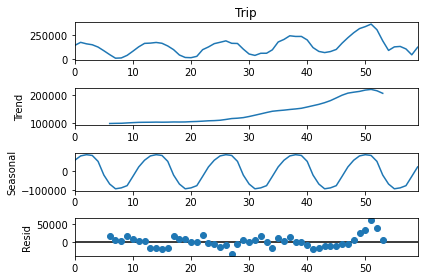

In [12]:
# Time Series Decomposition
# This method can be implemented with an “Additive” structure or a “Multiplicative” structure, where the choice of method depends on the data set. 
# use the qcement data for this part
# observe data components

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(bikes_df['Trip'], model='additive', period = 12)
result.plot()
pyplot.show()

#### b. Provide your forecasts using Holt-Winters’ method. [2 pts]


In [13]:
from statsmodels.tsa.api import ExponentialSmoothing

bikes_df_train = pd.DataFrame(bikes_df['Trip'][:-12])
Holts_Winters_forecast = []
bikes_df_train['Dates'] =  pd.date_range('6/1/2015', periods=48, freq='M')
bikes_df_train.set_index('Dates', inplace=True)

ES_bikes_df = ExponentialSmoothing(bikes_df_train['Trip'],trend='add', seasonal='add',seasonal_periods = 12, freq = 'M').fit()
Holts_Winters_forecast = ES_bikes_df.forecast(12)

bikes_df2 = init
bikes_df2 = pd.concat([bikes_df2, pd.Series(Holts_Winters_forecast.values, name ='Holts_Winters_forecast', index = bikes_df.index[-12:])], axis=1)
bikes_df2['Holts_Winters_forecast'] = bikes_df2['Holts_Winters_forecast'].round(0)

bikes_df2.tail(12)

C:\Users\tommy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\tommy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,Date,Trip,Holts_Winters_forecast
48,2019-06-01,274022,241245.0
49,2019-07-01,316931,264239.0
50,2019-08-01,337443,259998.0
51,2019-09-01,363185,248340.0
52,2019-10-01,305504,221377.0
53,2019-11-01,190759,161343.0
54,2019-12-01,92208,123617.0
55,2020-01-01,128598,109058.0
56,2020-02-01,133235,119135.0
57,2020-03-01,107350,134125.0


In [14]:
ES_bikes_df.summary()

Dep. Variable:,endog,No. Observations:,48
Model:,ExponentialSmoothing,SSE,8858750058.268
Optimized:,True,AIC,945.607
Trend:,Additive,BIC,975.546
Seasonal:,Additive,AICC,969.193
Seasonal Periods:,12,Date:,"Tue, 15 Sep 2020"
Box-Cox:,False,Time:,22:10:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3684471,alpha,True
smoothing_slope,2.659e-08,beta,True


In [15]:
print('MAD for Holts-Winters forecast: {:.1f}'.format(mean_absolute_error(Actual, Holts_Winters_forecast)))
print('MAD for Holts-Winters forecast: {:.1f}%'.format(Mape(Actual, Holts_Winters_forecast)))

MAD for Holts-Winters forecast: 61496.6
MAD for Holts-Winters forecast: 50.3%


#### c. Identification of best fit ARIMA model. Explain the resulting model, e.g., any (seasonal) differencing. [2 pts]


In [16]:
bikes_df_train = bikes_df2['Trip'][:-12]

import pmdarima as pm 
model = pm.auto_arima(bikes_df_train, seasonal = True, m=12, suppress_warnings=True) # m=seasonal length
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -394.273
Date:                            Tue, 15 Sep 2020   AIC                            794.545
Time:                                    22:10:47   BIC                            799.211
Sample:                                         0   HQIC                           796.156
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2913      0.146     -1.999      0.046      -0.577      -0.006
ma.S.L12      -0.2414      0.106     -2.272      0.023      -0.450      -0.033
sigma2      3.216e+08   3.19e-11   1.01e+19      0.000    3.22e+08    3.22e+08
===================================================================================
Ljung-Box (Q):                       28.59   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.73   Prob(JB):                         0.81
Heteroskedasticity (H):               0.93   Skew:                             0.20
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+35. Standard errors may be unstable.
"""

#### Observation:
(p = 0, d = 1, q = 1) (P = 0, D = 1, Q = 1, S = 12)
d= 1 with S= 12, The Auto ARIMA Model use one level diferencing to minimise the effect of data seasonality
The model is MA(1).

#### d. Plot ACF and PACF of fitted residuals to verify whether there is MA/AR effect left. [1 pt]

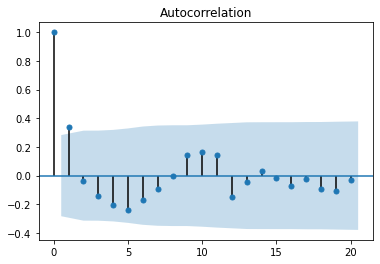

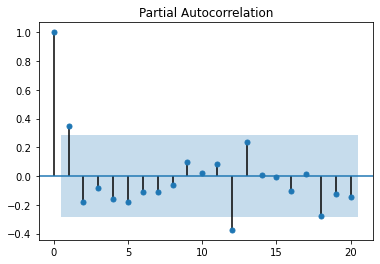

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(model.resid(),lags=20)
plt.show()
plot_pacf(model.resid(),lags=20)
plt.show()

#### Observation
Mostly the residual are within the baseline, with p = 2, q = 2, q = 12, that it is barely out of the baseline.
Therefore this will be a satsifactory model for the bluebike data.

#### e.Forecast the trips for 2019-06 to 2020-05 using the best fit ARIMA model and plot the predictions with 95% confidence intervals. [2 pts]


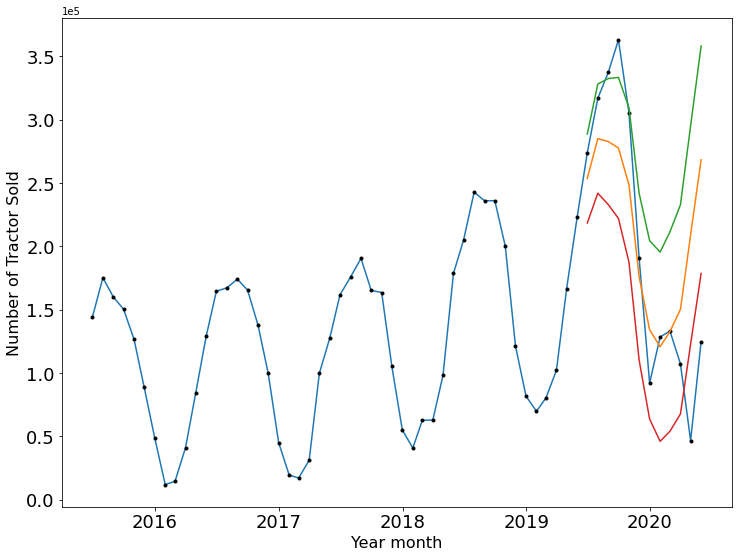

In [18]:
pred, conf = model.predict(12, return_conf_int=True,alpha=0.05)
pred

Test = pd.DataFrame()

Test['test_periods'] = pd.Series(pd.date_range('2019-06-01','2020-06-01', freq = 'M'))
Test['lower_bounds'] = [i[0] for i in conf ]
Test['upper_bounds'] = [i[1] for i in conf ]
Test['prediction'] = list(pred)

bikes_df_date = pd.Series(pd.date_range('2015-06-01','2020-06-01', freq = 'M'))

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( bikes_df_date, bikes_df['Trip'],linestyle = 'solid', markeredgecolor = 'black',markerfacecolor = 'black', markersize = 3)
ax1.plot_date( Test['test_periods'], Test['prediction'], linestyle = 'solid', markersize = 0)
ax1.plot_date( Test['test_periods'], Test['upper_bounds'], linestyle = 'solid', markersize=0)
ax1.plot_date( Test['test_periods'], Test['lower_bounds'], linestyle = 'solid', markersize=0)
ax1.ticklabel_format(axis = 'y', style= 'sci',scilimits =(0,3))
ax1.set_xlabel('Year month',fontsize=16)
ax1.set_ylabel('Number of Tractor Sold',fontsize=16)
plt.tick_params(labelsize=18)
plt.show() 

#### 5. Focus on the trip data from 2019-01 to 2019-12 only. Now the client of MSBA &Company wants to understand the key factors that affects the total daily ridership in the studied periods. Please explore auxiliary data sets and discuss your findings. [3 pts] 
[Hint: Weather data: https://www.meteoblue.com/en/weather/archive/era5/boston_united-states-of-america_4930956 . Students are also encouraged to explore other auxiliary data source]

In [19]:
data_df = pd.read_csv('dataexport_20200914T084245.csv', header = [4])
data_df = data_df.iloc[5:,]
data_df.columns = data_df.columns.map(''.join)

date = pd.to_datetime(data_df['variable'], errors='coerce').dt.date
data_df.drop('variable', axis=1, inplace=True)
data_df = data_df.astype('float64')
data_df['Date'] = date
data_agg = data_df.groupby('Date').mean()

#initialising the data
test = []
dateindex = []
mdate = []
data_2019 = pd.DataFrame()

#iterating the dates 
start_dt = datetime.date(2019,1,1)
end_dt = datetime.date(2020,1,1)
delta_dt = relativedelta(months=1)
while (start_dt < end_dt):
    mdate.append(start_dt)
    start_dt = start_dt + delta_dt
mdate = pd.Series(mdate, name = 'date')
mdate = pd.to_datetime(mdate).dt.strftime('%Y%m')

for mdate in mdate:
    data = pd.read_csv(str(mdate) + '-bluebikes-tripdata.csv')
    data['starttime'] = pd.to_datetime(data['starttime'],errors='coerce').dt.date
    data_2019 = pd.concat([data_2019, data], axis =0)
    temp_df = data['starttime'].groupby(data.starttime).count()
    for val in list(temp_df.values):
        test.append(val) 
    for ind in list(temp_df.index):
        dateindex.append(ind)

data_agg = pd.concat([data_agg, pd.Series(test, index= dateindex, name = 'Daily Trip')], axis=1)

In [20]:
data_agg.drop(['Temperature.1', 'Soil Temperature'], axis=1, inplace=True)
data_agg.columns

Index(['Temperature', 'Relative Humidity', 'Mean Sea Level Pressure',
       'Precipitation Total', 'Precipitation Runoff', 'Snowfall Amount',
       'Snow Depth', 'Cloud Cover Total', 'Cloud Cover High',
       'Cloud Cover Medium', 'Cloud Cover Low', 'Sunshine Duration',
       'Shortwave Radiation', 'Longwave Radiation', 'UV Radiation',
       'Direct Shortwave Radiation', 'Diffuse Shortwave Radiation',
       'Evapotranspiration', 'Potential Evaporation',
       'FAO Reference Evapotranspiration', 'CAPE', 'PBL Height', 'Wind Gust',
       'Wind Speed', 'Wind Direction', 'Geopotential Height',
       'Vapor Pressure Deficit', 'Total Column Cloud Ice',
       'Total Column Cloud Water', 'Daily Trip'],
      dtype='object')

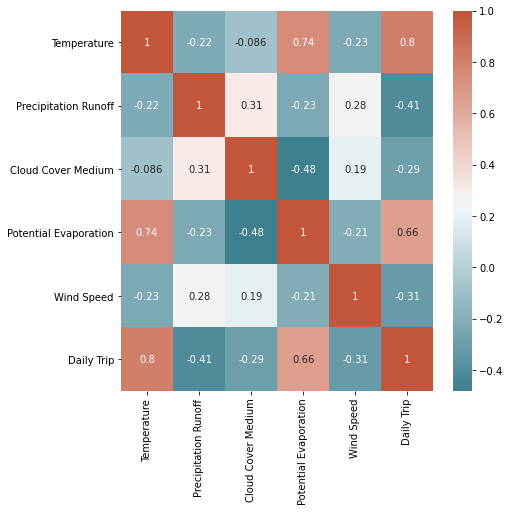

In [21]:
# filter off columns that has the highest corelation (20% of the whole data)
data_corr = data_agg.corr()
uplim = data_corr['Daily Trip'].quantile(q=0.90)
lowlim = data_corr['Daily Trip'].quantile(q=0.10)

col = data_corr[(data_corr['Daily Trip'] > uplim) | (data_corr['Daily Trip'] < lowlim)].index
data_viz = data_agg[col]

import seaborn as sns
plt.figure(figsize = (7,7))
cmap = sns.diverging_palette(215, 20, as_cmap=True)
sns.heatmap(data_viz.corr(), annot = True, cmap = cmap)

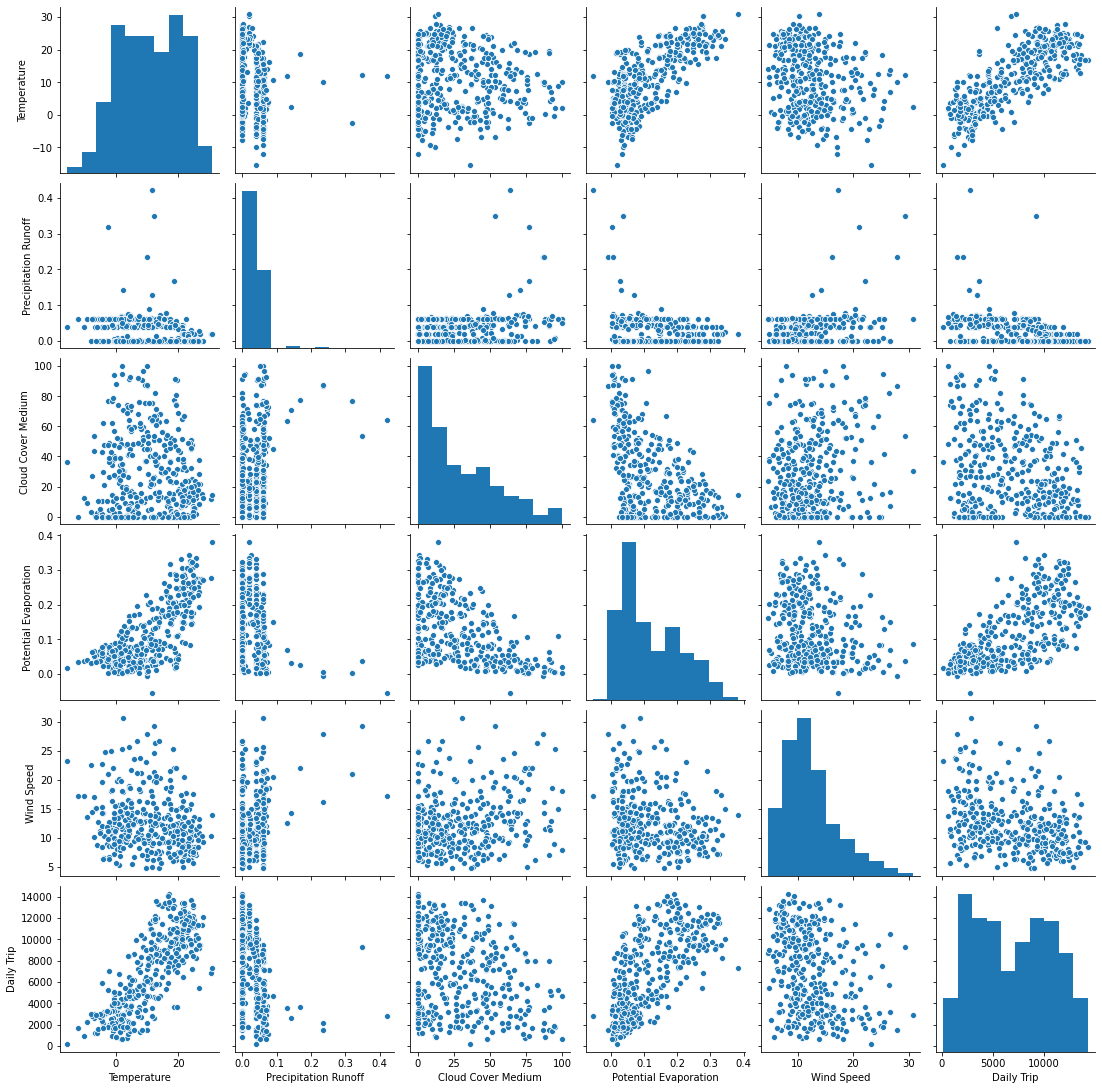

In [22]:
sns.pairplot(data_viz)

#### Observations:

We can see from the pair plot graphs, that Temperature, Cloud Cover Medium, Potential Evaporation and Wind Speed has some impacts on the Daily Trip. 
- As the **Temperature** goes low, daily ridership is dropping perhaps due to snow and cold temperature, customer are more reluctant (or even unable) for transportation
- **Cloud cover Medium** as it go higher, the total daily ridership is dropping, this may means raining, or snowing at the area (depending on the season)
- **Potential Evaporation** as it go higher, the total daily ridership is increasing, however it is also have the same trend with temperature, so it means that Potential Evaporation correlated with temperature, as the temperature goes higher, more evaporation happens
- As the **Wind Speed** is increasing, the daily readership having a trend down, we see weak correlation with other factors, which become an additional good factor to predict the ridership. One reason that may explain as the wind speed increases, it may become dangerous for the people to ride the bikes and hence lesser people take the bikes


#### 6. [Optional] Focus on the trip data during 2019-01 and 2019-12 only. Now, the client of MSBA & Company wants to understand the key factors that explains the difference in the (average daily) ridership between different pairs of origin and destination. Please explore auxiliary data sets and discuss your findings. [3pts]

In [23]:
from scipy.spatial.distance import pdist

station = pd.read_csv('Stations.csv')
st_id = station['Station Id']
station.sort_values('Station Id', inplace=True, ascending = True)

length = len(station)
list = [[0 for i in range(length)] for j in range(length)] 

for i in range(length):
    for j in range(length):
        list[i][j] = pdist([(station['Latitude'][i],station['Longitude'][i]),(station['Latitude'][j],station['Longitude'][j])]).round(4)[0]
dist_matrix = pd.DataFrame(list, columns = station['Station Id'], index = station['Station Id'])
dist_matrix

Station Id,3,4,5,6,7,8,9,10,11,12,...,434,435,436,437,440,441,442,443,445,446
Station Id,,,,,,,,,,,,,,,,,,,,,
3,0.0000,0.0262,0.0305,0.0257,0.0225,0.0290,0.0302,0.0491,0.0333,0.1018,...,0.0932,0.1051,0.0642,0.0844,0.0421,0.0647,0.0149,0.0482,0.0612,0.0266
4,0.0262,0.0000,0.0048,0.0105,0.0403,0.0311,0.0453,0.0323,0.0376,0.1025,...,0.0973,0.1103,0.0556,0.0693,0.0445,0.0466,0.0397,0.0503,0.0738,0.0076
5,0.0305,0.0048,0.0000,0.0102,0.0451,0.0314,0.0501,0.0285,0.0419,0.1008,...,0.0962,0.1094,0.0528,0.0653,0.0441,0.0423,0.0443,0.0496,0.0746,0.0111
6,0.0257,0.0105,0.0102,0.0000,0.0445,0.0212,0.0507,0.0248,0.0456,0.0921,...,0.0868,0.0999,0.0460,0.0618,0.0342,0.0402,0.0405,0.0399,0.0643,0.0178
7,0.0225,0.0403,0.0451,0.0445,0.0000,0.0515,0.0079,0.0692,0.0192,0.1237,...,0.1144,0.1258,0.0865,0.1057,0.0644,0.0847,0.0141,0.0705,0.0798,0.0362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.0647,0.0466,0.0423,0.0402,0.0847,0.0427,0.0909,0.0157,0.0842,0.0746,...,0.0759,0.0889,0.0247,0.0236,0.0426,0.0000,0.0796,0.0431,0.0734,0.0534
442,0.0149,0.0397,0.0443,0.0405,0.0141,0.0418,0.0216,0.0639,0.0318,0.1115,...,0.1015,0.1126,0.0777,0.0988,0.0535,0.0796,0.0000,0.0593,0.0661,0.0382
443,0.0482,0.0503,0.0496,0.0399,0.0705,0.0204,0.0783,0.0348,0.0798,0.0540,...,0.0472,0.0601,0.0249,0.0501,0.0062,0.0431,0.0593,0.0000,0.0305,0.0572


In [24]:
mask1 = data_2019['start station id'].isin(st_id)
mask2 = data_2019['end station id'].isin(st_id)
data_use = data_2019[mask1 & mask2]

trip_matrix = data_use.pivot_table(values = 'bikeid', index = 'start station id', columns = 'end station id', aggfunc = 'count').fillna(0)
trip_matrix

end station id,3,4,5,6,7,8,9,10,11,12,...,434,435,436,437,440,441,442,443,445,446
start station id,,,,,,,,,,,,,,,,,,,,,
3,514.0,33.0,256.0,13.0,3.0,29.0,138.0,73.0,195.0,521.0,...,0.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1.0,4.0
4,60.0,279.0,37.0,95.0,26.0,3.0,11.0,10.0,47.0,65.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0
5,311.0,25.0,491.0,26.0,2.0,35.0,93.0,60.0,328.0,148.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0
6,84.0,128.0,24.0,390.0,49.0,19.0,63.0,75.0,87.0,45.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,23.0,3.0,46.0,270.0,0.0,2.0,5.0,1.0,22.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0
442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0
443,7.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0,7.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


Data Frame rows before filter:  1555412
    starttime  start station id  end station id  no_trip
0  2019-01-01                 3              51        1
1  2019-01-01                 3              87        1
2  2019-01-01                 3             366        1
3  2019-01-01                 4               4        1
4  2019-01-01                 4              16        1
---------------------------------------------------------------------------
Data Frame rows after filter:  84853
Left: before filter, Right: after filter
       starttime  start station id  end station id  no_trip
894   2019-01-02                 5             342        1
2760  2019-01-03                 5             342        1
4790  2019-01-04                 5             342        2
7093  2019-01-05                 5             342        1
7712  2019-01-06                 5             342        2


Text(0.5, 1.0, 'Histogram of no of trips daily of station i to station j (filtered)')

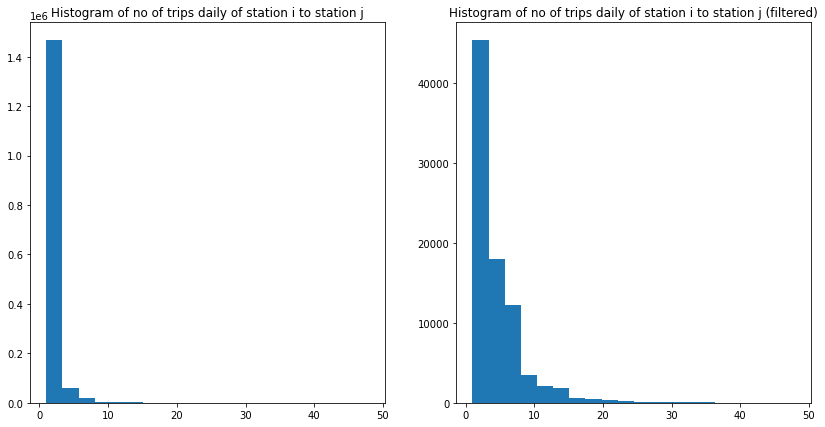

In [25]:
data_use = data_use[['starttime','start station id', 'end station id', 'tripduration', 'bikeid', 'usertype', 'birth year', 'gender']]
df = data_use.groupby(['starttime', 'start station id', 'end station id']).count()['bikeid']
df = df.reset_index()
df.columns = ['starttime', 'start station id', 'end station id', 'no_trip']
print('Data Frame rows before filter: ', len(df))
print(df.head())

plt.figure(figsize = (14,7))
plt.subplot(1,2,1)
plt.hist(df['no_trip'],bins = 20)
plt.title('Histogram of no of trips daily of station i to station j')

a = np.array(trip_matrix)
pos = np.argwhere(a > 700)
sid = []
eid = [] 
for i in pos:
    sid.append(trip_matrix.index[i[0]])
    eid.append(trip_matrix.columns[i[1]])

filtered_df = pd.DataFrame()
for x,y in zip(sid,eid):
    mask1 = df['start station id'] == x
    mask2 = df['end station id'] == y
    filtered_df = pd.concat([filtered_df, df[mask1 & mask2]], axis=0)

print('-'*75)
print('Data Frame rows after filter: ', len(filtered_df))
print('Left: before filter, Right: after filter')
print(filtered_df.head())
plt.subplot(1,2,2)
plt.hist(filtered_df['no_trip'], bins =20)
plt.title('Histogram of no of trips daily of station i to station j (filtered)')


#### Explanations:
The data has more than 1.4 million data in which, user use less than 3 per trips. This data will be of no use to be predicted and cause the calculation to be intensive. Therefore we will do strategy to remove the data. When the aggregate of the yearly data is less than 2 trip a day (700) then we will remove the trips data that is not useful to explain the factors affecting the daily ridership.
This method has managed to filter off ~95% of the data that is of no use for us

In [26]:
filtered_df.reset_index(drop = True, inplace = True )
dist = []
for i in range(len(filtered_df)):
    s = filtered_df['start station id'][i]
    e = filtered_df['end station id'][i]
    dist.append(dist_matrix[s][e])
filtered_df['distance'] = dist

data_merge = data_viz[['Temperature', 'Precipitation Runoff', 'Cloud Cover Medium', 'Wind Speed']]
filtered_df= filtered_df.merge(data_merge, left_on = 'starttime', right_index = True, how = 'left')
filtered_df= filtered_df.merge(station[['Station Id', 'Total docks']], left_on = 'start station id', right_on = 'Station Id', how='left')
filtered_df[['starttime', 'start station id', 'end station id', 'distance', 'Total docks', 'Temperature', 'Precipitation Runoff',
             'Cloud Cover Medium', 'Wind Speed', 'no_trip']].head(20)

,starttime,start station id,end station id,distance,Total docks,Temperature,Precipitation Runoff,Cloud Cover Medium,Wind Speed,no_trip
0,2019-01-02,5,342,0.0192,15,-0.883772,0.040000,10.666667,10.105483,1
1,2019-01-03,5,342,0.0192,15,2.654562,0.040000,30.333333,11.653486,1
2,2019-01-04,5,342,0.0192,15,3.625812,0.040000,0.916667,12.926744,2
3,2019-01-05,5,342,0.0192,15,3.663312,0.044167,74.333333,10.884510,1
4,2019-01-06,5,342,0.0192,15,2.356645,0.040000,15.500000,17.834325,2
5,2019-01-07,5,342,0.0192,15,-4.205022,0.040000,10.500000,15.251501,5
6,2019-01-09,5,342,0.0192,15,3.820395,0.043333,41.041667,16.488801,3
7,2019-01-10,5,342,0.0192,15,0.475395,0.040000,26.416667,19.740287,1
8,2019-01-11,5,342,0.0192,15,-4.429188,0.040000,0.166667,22.810319,4
9,2019-01-12,5,342,0.0192,15,-6.526689,0.040000,0.791667,15.004580,2


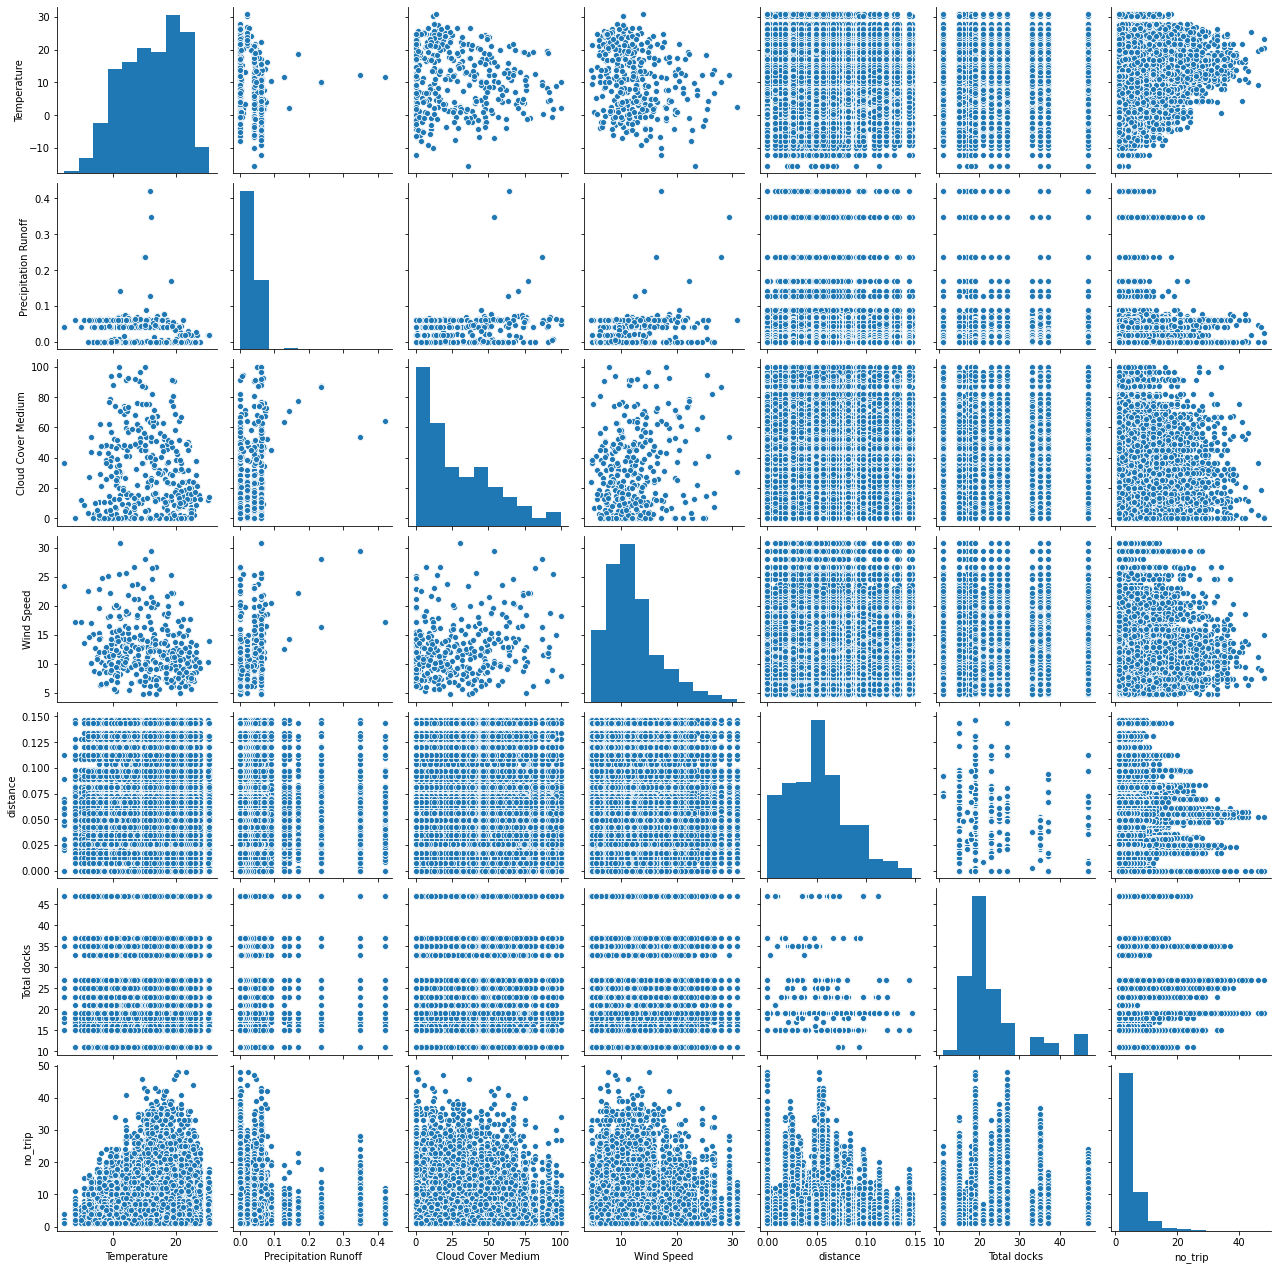

In [27]:
data_viz2 = filtered_df[['Temperature', 'Precipitation Runoff', 'Cloud Cover Medium',
       'Wind Speed', 'distance', 'Total docks', 'no_trip']]
sns.pairplot(data_viz2)

### Observations:
From the pairplot we can see the limiting effects of each factors to the no of trips:
1. As temperature drop down, the total ridership is also dropping down
2. As the Cloud Cover Mediumn is getting larger, the total ridership is also dropping down
3. As the Windspeed increase, the total ridership also increase (perhaps more windy hence people feels more comfortable), however as the it pass the values 10, we start to see the total ridership reduced
4. Distance & total docks has a parabolic effect to the no of trips

As I am running out of time, I stopped at this stage, however some observations that I feel can be improved to have a better understanding will be, to add categorical data of Season (transform into a dummy variable). Moreover, this data will be a good data to do Regression, however as my knowledge on Regression is still limited, so I did not try to attempt to use OLS, as some of the parameters may affect one another (such as temperature, wind, cloud cover e.g. when temperature is hot, while cloud cover is in the middle, it may increase the ridership, as the weather is not raining, and more cloudy).